<a href="https://colab.research.google.com/github/mich3leRusso/Deep_learning_last/blob/main/Model_Training_EarlyStopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip install kaggle
!pip install monai
!pip install 'monai[einops]'
!pip install "monai[fire]"

In [3]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
from monai.data import ImageReader
from skimage.io import imread
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
import random

import os
import glob

import monai
import numpy as np
import torch
from tqdm import tqdm, trange

from monai.networks.blocks import PatchEmbed, UnetOutBlock, UnetrBasicBlock, UnetrUpBlock
from monai.networks.nets import UNet
from monai.networks.layers import Norm


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [5]:
!kaggle competitions download -c bugnist2024fgvc

bugnist2024fgvc.zip: Skipping, found more recently modified local copy (use --force to force download)


# Sample submission based on 3D U-Net as a baseline

In this notebook, we'll go through a full attempt at a solution - albeit a poorly performing one.

**Full disclosure:** this notebook was not developed on Kaggle, but on another machine. It may not work out of the box but hopefully, it can serve as a useful starting point for now.

The idea is to train a 3D U-Net to segment the bugs based on the single bug images. Here, there is only one bug per image, so we can use the 3D U-Net to segment the bug. Since we know the label of the bugs in the single bug images, we can also train the U-Net to predict the bug type, by casting it as a multi-class segmentation problem (13 classes, 12 bugs + background). We can then use the segmentation to find its center point and use that for our submission.

In [6]:
extract_dir = '/content/'

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with ZipFile('/content/bugnist2024fgvc.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [7]:
# Path to individual bugs (change to where you store the bugs)
data_dir = '/content/BugNIST_DATA/train'

SEED = 1337

First, we gather all the files and their labels to prepare the data loaders.
We will store the labels as one-hot encoded vectors.

In [8]:
images = []
labels = []

class_names = os.listdir(data_dir)
class_image_files = [
    glob.glob(os.path.join(data_dir, name, '*')) for name in class_names
]

for i, files in enumerate(class_image_files):
    images += files

    labels_i = torch.zeros(len(files), len(class_names))
    labels_i[:, i] = 1
    labels.append(labels_i)


labels = torch.cat(labels, dim=0)

Some samples of the lists we made:

In [9]:
class_names

['PP', 'GH', 'MA', 'AC', 'SL', 'BC', 'BP', 'ML', 'WO', 'BF', 'BL', 'CF']

In [10]:
images[:5]

['/content/BugNIST_DATA/train/PP/fluepup_3_049.tif',
 '/content/BugNIST_DATA/train/PP/fluepup_3_109.tif',
 '/content/BugNIST_DATA/train/PP/fluepup_5_061.tif',
 '/content/BugNIST_DATA/train/PP/fluepup_4_021.tif',
 '/content/BugNIST_DATA/train/PP/fluepup_5_030.tif']

In [11]:
labels[:5]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Looks good! Let's split the individual images into a train and validation set:

In [12]:
from sklearn.model_selection import train_test_split

train_val_split = 0.7

train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, train_size=train_val_split, stratify=labels,
    random_state=SEED,
)

In [13]:
from monai.data import ImageReader
from skimage.io import imread

class TiffReader(ImageReader):
    def __init__(self):
        super().__init__()


    def get_data(self, img):
        return np.asarray(img), dict()


    def read(self, data, **kwargs):
        if isinstance(data, str):
            data = [data]

        return [imread(f) for f in data]


    def verify_suffix(self, filename):
        return filename.endswith('.tif') or filename.endswith('.tiff')


During the training pipeline, the rough idea is this:

1. Load a batch of images and their labels.
2. Segment the (single) bug using a threshold on the image intensity.
3. Use the label to turn the binary thresholded image into an actual segmentation mask.
4. Train the U-Net to predict the segmentation mask.

The solution here is based on the MONAI library, which provides building blocks for 3D image segmentations. Most of the above steps can be achieved via existing MONAI transforms we can add as data augmentations. However, we need two extra helper classes.

First, a class to tell it how to read our 3D tiff-files:

Next a class to copy an image

In [14]:
from copy import deepcopy
from monai.transforms import MapTransform

class CopyImaged(MapTransform):
    def __init__(self, key_to_copy, new_key, allow_missing_keys=False):
        super().__init__(key_to_copy, allow_missing_keys)
        self.key_to_copy = key_to_copy
        self.new_key = new_key


    def __call__(self, data):
        data = dict(data)
        data[self.new_key] = deepcopy(data[self.key_to_copy])
        return data


We can now set up our transforms:

In [15]:
import monai.transforms as T
from skimage.io import imread

# Precompute padding to get equal side lengths
im0 = imread(images[0])
shape = torch.tensor(im0.shape)
padding = (0, int((shape[0] - shape[1]) // 2), int((shape[0] - shape[2]) // 2))

# Prepare train and test data loaders
keys = ['image', 'mask']
train_transforms = T.Compose([
    # Load the image
    T.LoadImaged(keys='image', reader=TiffReader, image_only=True),
    T.Resized(keys='image', spatial_size=shape),
    # Scale the intensity
    T.ScaleIntensityd(keys='image'),
    # Pad the image so all sides are equal
    T.BorderPadd(keys='image', spatial_border=padding),
    # Make a copy of the image, which is what will later be our mask
    CopyImaged(key_to_copy='image', new_key='mask'),
    # Smooth the image and then threshold it
    T.GaussianSmoothd(keys='mask', sigma=2),
    T.AsDiscreted(keys='mask', threshold=0.25, dtype=torch.long),
    # Only keep the largest connected component as the bug mask
    T.KeepLargestConnectedComponentd(keys='mask', applied_labels=[0]),
    # Apply normal data augmentations
    T.EnsureTyped(keys=['image', 'mask', 'label'], track_meta=False),
    T.RandAffined(
        keys=['image', 'mask'], prob=0.95, rotate_range=(np.pi/2,) * 3,
        translate_range=shape // torch.tensor([2, 1, 1]), padding_mode='zeros'),
    T.RandAxisFlipd(keys=keys, prob=0.5),
    T.RandScaleIntensityd(keys='image', factors=0.25, prob=0.5),
    T.RandZoomd(keys=keys, prob=0.5),
    T.SqueezeDimd(keys='mask'),
    T.CastToTyped(keys='mask', dtype=torch.long),
])

val_transforms = T.Compose([
    # See train_transforms
    T.LoadImaged(keys='image', reader=TiffReader, image_only=True),
    T.Resized(keys='image', spatial_size=shape),
    T.ScaleIntensityd(keys='image'),
    T.BorderPadd(keys='image', spatial_border=padding),
    CopyImaged(key_to_copy='image', new_key='mask'),
    T.GaussianSmoothd(keys='mask', sigma=2),
    T.AsDiscreted(keys='mask', threshold=0.25, dtype=torch.long),
    T.KeepLargestConnectedComponentd(keys='mask', applied_labels=[0]),
    T.EnsureTyped(keys=['image', 'mask', 'label'], track_meta=False),
    T.SqueezeDimd(keys='mask'),
    T.CastToTyped(keys='mask', dtype=torch.long),
])

Let's quickly run through how this looks like when the code runs.

We create our `Dataset`s

In [16]:
from monai.data import Dataset

train_data = Dataset(
    [{ 'image': f, 'label': l }
        for f, l in zip(train_images, train_labels)],
    transform=train_transforms,
)

val_data = Dataset(
    [{ 'image': f, 'label': l }
     for f, l in zip(val_images, val_labels)],
    transform=val_transforms,
)

...and `DataLoaders`

In [17]:
from monai.data import DataLoader

train_batch_size = 4
val_batch_size = 2

train_loader = DataLoader(
    train_data,
    shuffle=True,
    num_workers=0,
    batch_size=train_batch_size,
)
val_loader = DataLoader(
    val_data,
    num_workers=0,
    shuffle=False,
    batch_size=val_batch_size,
)

Get a batch and look at it:

In [18]:
for i, batch in enumerate(train_loader):
    if i == 1:
      break

In [19]:
batch.keys()

dict_keys(['image', 'label', 'mask'])

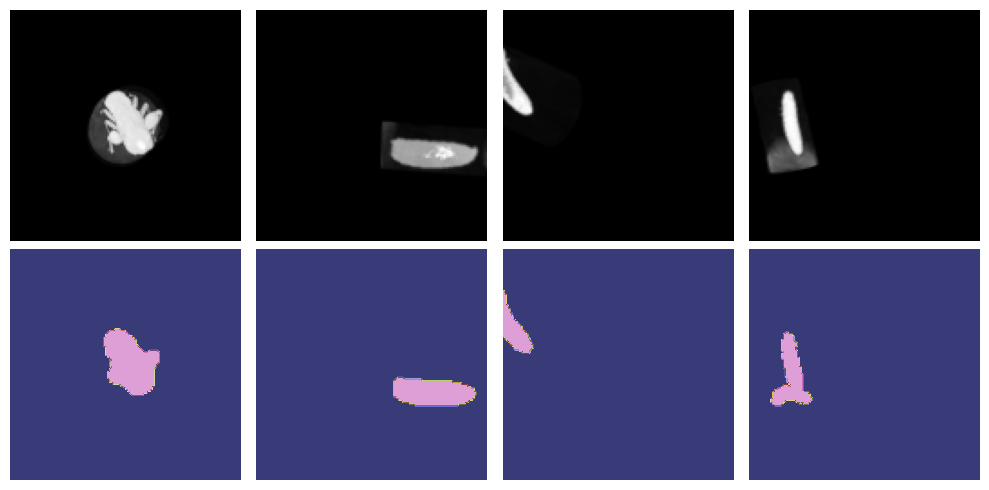

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(10, 5))
for i in range(4):
    ax[0, i].imshow(batch['image'][i, 0].cpu().numpy().max(axis=0), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(batch['mask'][i].cpu().numpy().max(axis=0), cmap='tab20b', vmin=0, vmax=1)
    ax[1, i].axis('off')
fig.tight_layout()

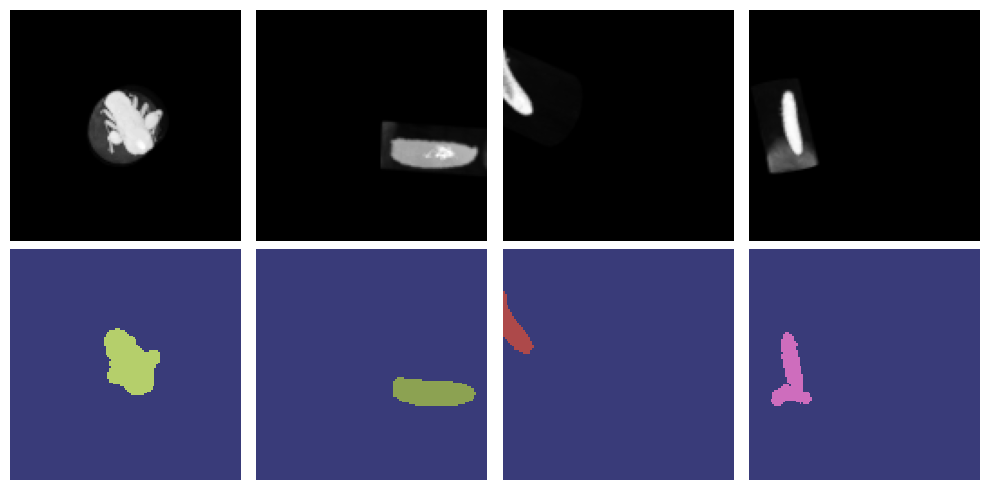

In [21]:
mask_label = batch['mask'] * (batch['label'].argmax(dim=1).view(-1, 1, 1, 1) + 1)

fig, ax = plt.subplots(2, 4, figsize=(10, 5))
for i in range(4):
    ax[0, i].imshow(batch['image'][i, 0].cpu().numpy().max(axis=0), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(mask_label[i].cpu().numpy().max(axis=0), cmap='tab20b',
                    vmin=0, vmax=len(class_names), interpolation='none')
    ax[1, i].axis('off')
fig.tight_layout()

Alright, now for real:

In [22]:
train_batch_size = 12
val_batch_size = 8

train_loader = DataLoader(
    train_data,
    shuffle=True,
    num_workers=8,
    batch_size=train_batch_size,
    drop_last=True,
)
val_loader = DataLoader(
    val_data,
    num_workers=8,
    shuffle=False,
    batch_size=val_batch_size,
    drop_last=True,
)

We use the built in U-Net implementation from MONAI:

In [23]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    #out_channels=2,
    out_channels=len(class_names) + 1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [24]:
weights = torch.load("/content/drive/MyDrive/unet_spleen_model.pt")
model_dict = model.state_dict()

# Fiter out missing keys, different or with different values' shapes (e.g. output layer)
filtered_dict = {k: v for k, v in weights.items() if k in model_dict and v.shape == model_dict[k].shape}
model_dict.update(filtered_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [25]:
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(class_names) + 1,  # Bug classes and background
    channels=(32, 64, 128, 256),
    strides=(2, 2, 2),
    num_res_units=2,
).to(device)'''

'\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel = monai.networks.nets.UNet(\n    spatial_dims=3,\n    in_channels=1,\n    out_channels=len(class_names) + 1,  # Bug classes and background\n    channels=(32, 64, 128, 256),\n    strides=(2, 2, 2),\n    num_res_units=2,\n).to(device)'

In [26]:
'''from monai.networks.nets import SwinUNETR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(128, 128, 128),
    in_channels=1,
    #out_channels=len(class_names) + 1,
    out_channels=14,
    feature_size=48,
    use_checkpoint=True,
).to(device)'''

'from monai.networks.nets import SwinUNETR\n\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\nmodel = SwinUNETR(\n    img_size=(128, 128, 128),\n    in_channels=1,\n    #out_channels=len(class_names) + 1,\n    out_channels=14,\n    feature_size=48,\n    use_checkpoint=True,\n).to(device)'

In [27]:
'''weights = torch.load("/content/drive/MyDrive/swin_unetr.pt")
model.load_state_dict(weights)
model_unetr.load_from(weights=weight)
model.out = UnetOutBlock(spatial_dims=3, in_channels=1, out_channels=len(class_names) + 1)
'''

'weights = torch.load("/content/drive/MyDrive/swin_unetr.pt")\nmodel.load_state_dict(weights)\nmodel_unetr.load_from(weights=weight)\nmodel.out = UnetOutBlock(spatial_dims=3, in_channels=1, out_channels=len(class_names) + 1)\n'

We use a mix of cross entropy and Dice loss. For the cross entropy loss, we weigh class 0 (background) with 0.1, since there's a lot of it.

In [28]:
ce_weight = torch.ones(len(class_names) + 1, device='cuda')
ce_weight[0] = 0.1

loss_fn = monai.losses.DiceCELoss(
    ce_weight=ce_weight,
    to_onehot_y=True,
    softmax=True,
    include_background=True,
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.losses.dice DiceCELoss.__init__:ce_weight: Argument `ce_weight` has been deprecated since version 1.2. It will be removed in version 1.4. please use `weight` instead.
  warn_deprecated(argname, msg, warning_category)


Define function to mix the images together

In [29]:
def mix_images(originals, masks):
    """
    Mixes multiple 3D images without overlapping non-zero values.

    Args:
        masks (torch.Tensor): Tensor containing multiple 3D images.

    Returns:
        torch.Tensor: Mixed images.
    """
    #print(f'masks: {type(masks)}, {masks.dtype}')

    #print(f'originals: {type(originals)}, {originals.dtype}')

    batch_size, depth, height, width = masks.shape
    #print(f'd: {depth}, h: {height}, w: {width}')

    mixed_masks = torch.zeros_like(masks)
    mixed_originals = torch.zeros_like(originals)
    #print(mixed_masks.shape)

    for batch_idx in range(batch_size):
        # Get the current image
        current_mask = masks[batch_idx]
        current_original = originals[batch_idx]

        final_indices = [batch_idx]
        #print(f'batch_idx: {batch_idx}')

        # Randomly select a subset of images
        num_images_to_mix = random.randint(0, batch_size-1)
        #print(f'num_images_to_mix: {num_images_to_mix}')
        final_masks = [current_mask]
        final_originals = [current_original]

        while len(final_indices)-1 < num_images_to_mix:
          samples = random.sample(range(batch_size), 1)
          index = samples[0]
          if index not in final_indices:
            #print(f'index: {index}')
            final_indices.append(index)
            final_masks.append(masks[index])
            final_originals.append(originals[index])

        # Create a canvas to overlay images without overlapping non-zero values
        canvas_original = torch.zeros_like(current_original)
        canvas_mask = torch.zeros_like(current_mask)
        #print("Overlay")

        # Iterate over the masks
        for i, mask in enumerate(final_masks):
            non_zero_locations = mask.nonzero()
# SHOULD CHANGE ANY TO ALL
            has_zeros_in_locations = (canvas_mask[non_zero_locations[:, 0], non_zero_locations[:, 1], non_zero_locations[:, 2]] == 0).all()

            if has_zeros_in_locations:
              canvas_mask += mask
              canvas_original += final_originals[i]

        mixed_masks[batch_idx] = canvas_mask
        mixed_originals[batch_idx] = canvas_original

    return mixed_originals, mixed_masks

In [30]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, mode='min', baseline=None):
        """
        Early stopping to terminate training when a metric doesn't improve after a given number of epochs.

        Args:
            patience (int): How many epochs to wait before stopping if no improvement.
            min_delta (float): Minimum change in the monitored metric to qualify as an improvement.
            mode (str): 'min' for a metric that should decrease, 'max' for a metric that should increase.
            baseline (float): An initial baseline to compare against.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best_metric = baseline
        self.wait = 0
        self.early_stop = False

        if mode == 'min':
            self.best_metric = float('inf') if baseline is None else baseline
        elif mode == 'max':
            self.best_metric = float('-inf') if baseline is None else baseline
        else:
            raise ValueError("Mode should be 'min' or 'max'")

    def update(self, current_metric):
        """
        Updates the early stopping status.

        Args:
            current_metric (float): Current value of the monitored metric.
        """
        if self.mode == 'min':
            improved = (current_metric < self.best_metric - self.min_delta)
        else:  # 'max'
            improved = (current_metric > self.best_metric + self.min_delta)

        if improved:
            self.best_metric = current_metric
            self.wait = 0
            self.early_stop = False
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.early_stop = True


 Run the training. This will take several hours sadly...

In [31]:
# Initialize early stopping with a patience of 5 epochs and no minimum change required for improvement
early_stopping = EarlyStopping(patience=5, min_delta=0, mode='min')

val_every = 1

max_epochs = 40

train_losses = []
val_losses = []
epoch_train_losses = []
epoch_val_losses = []
val_loss_mean = None
best_metric = float('inf')
model_path = 'best_model.pth'  # Path to save the best model

torch.cuda.empty_cache()

for epoch in range(max_epochs):
    model.train()

    loss_mean = 0
    num_batches = 0
    for batch in tqdm(train_loader):
        inputs = batch['image'].cuda()
        label = batch['label'].argmax(dim=1).cuda()
        expected = batch['mask'].cuda() * (label.view(-1, 1, 1, 1) + 1)

        inputs, expected = mix_images(inputs, expected)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, expected.unsqueeze(1))

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            loss_mean += loss.item()
            num_batches += 1
            train_losses.append(loss.item())


    loss_mean /= num_batches
    epoch_train_losses.append(loss_mean)

    if epoch % val_every == 0:
        model.eval()

        val_loss_mean = 0
        num_batches = 0
        for batch in tqdm(val_loader):
            inputs = batch['image'].cuda()
            label = batch['label'].argmax(dim=1).cuda()
            expected = batch['mask'].cuda() * (label.view(-1, 1, 1, 1) + 1)

            inputs, expected = mix_images(inputs, expected)

            with torch.no_grad():
                outputs = model(inputs)
                loss = loss_fn(outputs, expected.unsqueeze(1))
                val_loss_mean += loss.item()
                num_batches += 1
                val_losses.append(loss.item())

        val_loss_mean /= num_batches
        epoch_val_losses.append(val_loss_mean)

        # If the model improved, save it
        if val_loss_mean < best_metric:
            best_metric = val_loss_mean
            torch.save(model.state_dict(), model_path)
            print("Saving new best model")

        # Update early stopping with the current validation loss
        early_stopping.update(val_loss_mean)

        # If early stopping is triggered, break the training loop
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    # Save a checkpoint at the end of each epoch
    checkpoint = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'epoch_train_losses': epoch_train_losses,
        'epoch_val_losses': epoch_val_losses,
        'best_metric': best_metric,
    }
    torch.save(checkpoint, 'latest_model.ckpt')

    print(f"Epoch {epoch + 1}, loss: {loss_mean:.4f}, val. loss: {val_loss_mean:.4f}")

  0%|          | 0/533 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 26%|██▌       | 138/533 [03:51<11:02,  1.68s/it]


KeyboardInterrupt: 

Plot the training and validation losses

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#----------------------------- TRAINING -----------------------------

# Calculate the total number of iterations
total_iterations = len(train_losses)
# Calculate the number of iterations per epoch
iterations_per_epoch = total_iterations // len(epoch_train_losses)

# Generate x-axis ticks corresponding to the epochs
epoch_ticks = np.arange(0, total_iterations, iterations_per_epoch)

# Plot training loss with epoch ticks
plt.plot(train_losses, label='Training Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xticks(epoch_ticks, np.arange(1, len(epoch_train_losses) + 1))  # Set epoch numbers as ticks
plt.legend()
plt.show()

#----------------------------- VALIDATION -----------------------------

# Calculate the total number of iterations
total_iterations = len(val_losses)
# Calculate the number of iterations per epoch
iterations_per_epoch = total_iterations // len(epoch_val_losses)

# Generate x-axis ticks corresponding to the epochs
epoch_ticks = np.arange(0, total_iterations, iterations_per_epoch)

# Plot validation loss with epoch ticks
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.xticks(epoch_ticks, np.arange(1, len(epoch_val_losses) + 1))  # Set epoch numbers as ticks
plt.legend()
plt.show()

In [ ]:
epoch

Let's see the val losses

In [ ]:
plt.plot(epoch_val_losses)

Not much and then we suddenly drop to good performance. Weird, but we'll take it for now.

It would likely be smart to look further into this - but for now, let's just use the trained model to predict the test set.

## Predictions on single bugs

First, we'll try it out on the validation examples with single bugs, just as a sanity check that it works for the trained task. To do this, we'll make a helper function:

In [ ]:
# Load the state dictionary
model_path = 'best_model.pth'
state_dict = torch.load(model_path)

# Apply the state dictionary to your model
model.load_state_dict(state_dict)

In [ ]:
from skimage import measure

def predict(image):
    with torch.no_grad():
        pred = model(image)
    pred_sm = pred.softmax(dim=1).cpu().numpy()
    class_props = []
    for i in range(1, 13):
        props = measure.regionprops(
            measure.label(pred_sm[0, i] > 0.5)
        )
        props = [p for p in props if p.area > 5**3]
        class_props.append(props)

    boxes = np.array([p.bbox for props in class_props for p in props])
    centers = np.array([p.centroid for props in class_props for p in props])
    labels = np.array([i + 1 for i, props in enumerate(class_props) for p in props])
    scores = np.ones(len(boxes))
    return {
        'boxes': boxes,
        'centers': centers,
        'labels': labels,
        'scores': scores,
        'pred': pred_sm,
    }

Now, load an image and run a prediction:

In [ ]:
from skimage.io import imread

fname = val_images[70]
image = imread(fname)
print(fname)

In [ ]:
image = np.pad(image / 255.0, ((0, 0), (32, 32), (32, 32)))
pred = predict(torch.tensor(image[None, None]).float().cuda())

In [ ]:
np.unique(pred['pred'][0].argmax(axis=0))

In [ ]:
from matplotlib.patches import Rectangle

a = 1

#fig, ax = plt.subplots(figsize=(10, 10))
fig, ax = plt.subplots()
ax.imshow(image.max(axis=a), cmap='gray')
ax.imshow(pred['pred'][0].argmax(axis=0).max(axis=a), alpha=0.5, interpolation='none')
for box, center, label in zip(pred['boxes'], pred['centers'], pred['labels']):
    if a == 0:
        center = (center[2] - 0.5, center[1] - 0.5)
        xy = (box[2] - 0.5, box[1] - 0.5)
        height = box[4] - box[1]
        width = box[5] - box[2]
    elif a == 1:
        center = (center[2] - 0.5, center[0] - 0.5)
        xy = (box[2] - 0.5, box[0] - 0.5)
        height = box[3] - box[0]
        width = box[5] - box[2]
    else:
        center = (center[1] - 0.5, center[0] - 0.5)
        xy = (box[1] - 0.5, box[0] - 0.5)
        height = box[3] - box[0]
        width = box[4] - box[1]
    ax.add_patch(
        Rectangle(xy, width, height, edgecolor='r', facecolor='none'))
    ax.plot(center[0], center[1], 'ro')
    ax.text(xy[0], xy[1] - 1, class_names[label - 1], color='r')

# Predictions on mixed volumes

Satisfied it works on the single bugs, we'll now try the validation examples with a mixture of bugs:

In [ ]:
validation_dir = '/content/BugNIST_DATA/validation/'

In [ ]:
mixed_images = sorted(glob.glob(validation_dir + '*.tif'))

In [ ]:
fname = mixed_images[10]
image = imread(fname)
image = np.pad(image / 255.0, ((0, 0), (18, 18), (18, 18)))  # Pad to even side length
image.shape

In [ ]:
plt.imshow(image.max(axis=1), cmap='gray')

In [ ]:
pred = predict(torch.tensor(image[None, None]).float().cuda())

In [ ]:
np.unique(pred['pred'][0].argmax(axis=0))

In [ ]:
from matplotlib.patches import Rectangle

a = 2

#fig, ax = plt.subplots(figsize=(10, 10))
fig, ax = plt.subplots()
ax.imshow(image.max(axis=a), cmap='gray')
ax.imshow(pred['pred'][0].argmax(axis=0).max(axis=a), alpha=0.5, interpolation='none')
for box, center, label in zip(pred['boxes'], pred['centers'], pred['labels']):
    if a == 0:
        center = (center[2] - 0.5, center[1] - 0.5)
        xy = (box[2] - 0.5, box[1] - 0.5)
        height = box[4] - box[1]
        width = box[5] - box[2]
    elif a == 1:
        center = (center[2] - 0.5, center[0] - 0.5)
        xy = (box[2] - 0.5, box[0] - 0.5)
        height = box[3] - box[0]
        width = box[5] - box[2]
    else:
        center = (center[1] - 0.5, center[0] - 0.5)
        xy = (box[1] - 0.5, box[0] - 0.5)
        height = box[3] - box[0]
        width = box[4] - box[1]
    ax.add_patch(
        Rectangle(xy, width, height, edgecolor='r', facecolor='none'))
    ax.plot(center[0], center[1], 'ro')
    ax.text(xy[0], xy[1] - 1, class_names[label - 1], color='r')

Performance is not *great*, but it's finding something. This is to be expected when the model has only seen single bugs during training. Someone should get on that ;-)

Let's now try to format our predictions in the competition format. First, we load the sample CSV file

In [ ]:
import pandas as pd

validation = pd.read_csv(validation_dir + 'validation.csv')

In [ ]:
validation.set_index('filename', inplace=True)
validation

Now, let's load the row corresponding to our current file

In [ ]:
from pathlib import Path

fname = Path(fname)
fname.name

and unpack it to get the points

In [ ]:
val_string = validation.loc[fname.name][0]
true_labels = val_string.split(';')[::4]
true_centers = np.array([
    [float(x) for x in val_string.split(';')[1::4]],
    [float(x) for x in val_string.split(';')[2::4]],
    [float(x) for x in val_string.split(';')[3::4]],
]).T

true_centers = true_centers[:, [2, 1, 0]]
true_centers += np.array([[0, 18, 18]])

print(true_labels)
print(true_centers)

Let's now plot them. Importantly, we use the same plotting code as before, so we can be fairly confident that our predictions have the correct coordinates

In [ ]:
a = 1

#fig, ax = plt.subplots(figsize=(10, 10))
fig, ax = plt.subplots()
ax.imshow(image.max(axis=a), cmap='gray')
for center, label in zip(true_centers, true_labels):
    if a == 0:
        center = (center[2] - 0.5, center[1] - 0.5)
    elif a == 1:
        center = (center[2] - 0.5, center[0] - 0.5)
    else:
        center = (center[1] - 0.5, center[0] - 0.5)
    ax.plot(center[0], center[1], 'ro')
    ax.text(center[0], center[1] - 1, label, color='r')

Looks good. Let's now make a helper function that takes a list of points and packs into the format needed for a competition solution:

In [ ]:
def pack_prediction(centers, labels):
    if centers.shape == (0,):
      print("Found empty prediction..")
      return
    centers = centers - np.array([[0, 18, 18]])
    strings = []
    for l, c in zip(labels, centers):
        strings.append(f"{l};{c[2]};{c[1]};{c[0]}")
    return ";".join(strings)

Testing it out:

In [ ]:
validation.loc[fname.name][0]

In [ ]:
pack_prediction(true_centers, true_labels)

Looks good. It packs the data back to the same format.

Now, we need to convert our prediction labels to the string labels used in the competition:

In [ ]:
pred_text_labels = [class_names[l - 1].lower() for l in pred['labels']]
pred_text_labels

and we can now build a competition submission row for this image:

In [ ]:
pack_prediction(pred['centers'], pred_text_labels)

Let's now run a prediction run on all the validation volumes

In [ ]:
submission = {
    'filenames': [],
    'centerpoints': [],
}

for fname in tqdm(mixed_images):
    image = imread(fname)
    image = np.pad(image / 255.0, ((0, 0), (18, 18), (18, 18)))
    pred = predict(torch.tensor(image[None, None]).float().cuda())
    pred_text_labels = [class_names[l - 1].lower() for l in pred['labels']]
    pred_text = pack_prediction(pred['centers'], pred_text_labels)
    submission['filenames'].append(Path(fname).name)
    submission['centerpoints'].append(pred_text)

In [ ]:
print(pred['centers'])
print(pred_text_labels)

Our submission would then be:

In [ ]:
submission = pd.DataFrame(submission)
submission

Which matches the format from the supplied csv file:

In [ ]:
validation

# Predictions on public test volumes

Finally, we can run a prediction run for the actual test volumes to build an actual submission:

In [ ]:
test_dir = '/content/BugNIST_DATA/test/'

In [ ]:
mixed_images = sorted(glob.glob(test_dir + '*.tif'))

In [ ]:
submission = {
    'filename': [],
    'centerpoints': [],
}
for fname in tqdm(mixed_images):
    image = imread(fname)
    image = np.pad(image / 255.0, ((0, 0), (18, 18), (18, 18)))
    pred = predict(torch.tensor(image[None, None]).float().cuda())
    pred_text_labels = [class_names[l - 1].lower() for l in pred['labels']]
    pred_text = pack_prediction(pred['centers'], pred_text_labels)
    submission['filename'].append(Path(fname).name)
    submission['centerpoints'].append(pred_text)

In [ ]:
submission = pd.DataFrame(submission)
submission

In [ ]:
submission.to_csv('submission.csv', index=False)

That's it - ready to submit!